In [4]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [5]:
# BRING IN DATA: BART, CA COUNTIES, CA PROTECTED AREAS DATABASE (CPAD)
BART_df = gpd.read_file('data/BART_Stations.shp')
CA_counties_df = gpd.read_file('data/CA_Counties/CA_Counties_TIGER2016.shp')
CPAD_df = gpd.read_file('data/CPAD_2022a/CPAD_2022a_Units.shp')

In [6]:
# PROJECT All TO EPSG:2227 (State Plane III)
State_PlaneIII = 'EPSG:2227'
BART_Orig_proj = 'EPSG:9707'
BART_df = BART_df.to_crs(State_PlaneIII)
CA_counties_df = CA_counties_df.to_crs(State_PlaneIII)
CPAD_df = CPAD_df.to_crs(State_PlaneIII)

In [7]:
# SUBSET TO BEGIN: JUST OAKLAND
place_name = 'Oakland, CA, USA' # FOR ALL EAST BAY: ['Alameda County, CA, USA', 'Contra Costa County, CA, USA']
area = ox.geocode_to_gdf(place_name)
area = area.to_crs(State_PlaneIII)
graph = ox.graph_from_place(place_name, network_type='bike')
graph_proj = ox.project_graph(graph, to_crs=State_PlaneIII)
nodes, edges = ox.graph_to_gdfs(graph_proj)

In [8]:
# ADJUST & FILTER DATA
county_list = ['Alameda', 'Contra Costa']
EB_counties = CA_counties_df[CA_counties_df['NAME'].isin(county_list)]

# BART & BUFFER
EBBART_df = BART_df.clip(area)
EBBART_df = EBBART_df[['Name','geometry']]
EBBART_dict = dict(zip(EBBART_df['Name'], EBBART_df.index))
EBBART_df_buff = EBBART_df.buffer(7500)

# PARKS
CPAD_df['Centroids'] = CPAD_df.centroid
EB_CPAD = CPAD_df[CPAD_df['COUNTY'].isin(county_list)]
EB_CPAD = EB_CPAD.loc[EB_CPAD['ACCESS_TYP'] == 'Open Access']
EB_CPAD = EB_CPAD.loc[EB_CPAD['ACRES'] > 3]
EB_CPAD_centroids = gpd.GeoDataFrame({'Name': EB_CPAD['UNIT_NAME'], 'Agency': EB_CPAD['AGNCY_NAME'], 'Acres': EB_CPAD['ACRES'], 
'geometry': EB_CPAD['Centroids']})
EB_Parks = EB_CPAD_centroids.clip(area).clip(EBBART_df_buff)

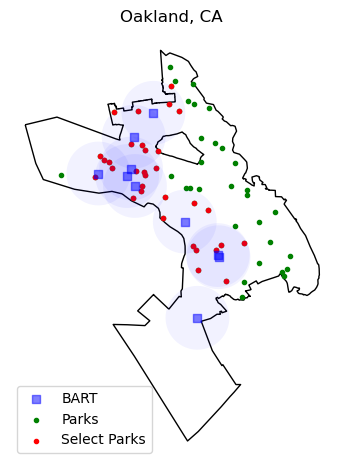

In [9]:
# VISUALIZE
fig, ax = plt.subplots(tight_layout = True)
EBBART_df.plot(ax=ax, color = 'b', marker = ',', alpha = 0.5, zorder = 4)
area.plot(ax=ax, ec='k', fc='w')
EB_CPAD_centroids.clip(area).plot(ax=ax, color = 'g', marker = '.')
EBBART_df_buff.plot(ax=ax, color = 'b', alpha = 0.05, zorder = 5)
EB_Parks.plot(ax=ax, color = 'r', marker = '.')
ax.axis('off')
ax.legend(['BART', 'Parks', 'Select Parks'], loc='lower left')
ax.set_title('Oakland, CA')
fig.savefig('Raw_Data_Vis.jpg')

In [13]:
def park_chooser(origin_point, dest_point):
    """
    Chooses random parks that fall within the intersection of origin point
    and destination point buffers. Then makes sure random parks are not too 
    close, and sequence them based on which park is closest to the 
    destination point. Returns park names, coordinates, the limit polygon,
    and the Parks dataframe.
    """

    # CREATE PARK LIMIT THROUGH BUFFER AND INTERSECTION
    dist = origin_point.distance(dest_point)
    orig_buff = origin_point.buffer(dist+1000)
    dest_buff = dest_point.buffer(dist+1000)
    park_limit = orig_buff.intersection(dest_buff)
    EB_Parks_limit = EB_Parks.clip(park_limit)

    # SAMPLE RANDOM PARKS AND GET X, Y VARIABLES
    park1_random = EB_Parks_limit.sample().index[0]
    park2_random = EB_Parks_limit.sample().index[0]
    park1_pt = EB_Parks.loc[park1_random]
    park2_pt = EB_Parks.loc[park2_random]
    park1_name = park1_pt['Name']
    park2_name = park2_pt['Name']
    park1_x, park1_y = park1_pt['geometry'].x, park1_pt['geometry'].y
    park2_x, park2_y = park2_pt['geometry'].x, park2_pt['geometry'].y
    park1_coord = Point(park1_x, park1_y)
    park2_coord = Point(park2_x, park2_y)

    # KEEP PARKS FROM BEING TOO CLOSE TOGETHER AND SEQUENCE PARKS ALONG THE ROUTE
    if park1_coord.distance(park2_coord) < 3000:
        park2_random = EB_Parks_limit.sample().index[0]
        park2_pt = EB_Parks.loc[park2_random]
        park2_x, park2_y = park2_pt['geometry'].x, park2_pt['geometry'].y
        park2_coord = Point(park2_x, park2_y)
        park2_name = park2_pt['Name']
    elif dest_point.distance(park1_coord) > dest_point.distance(park2_coord):
        return park1_name, park1_coord, park2_name, park2_coord, park_limit, EB_Parks_limit
    else:
        return park2_name, park2_coord, park1_name, park1_coord, park_limit, EB_Parks_limit

In [23]:
# START & END BART STATIONS
Start_BART = EBBART_dict['Rockridge'] # Examples
End_BART = EBBART_dict['12th St/Oakland City Center'] # Examples

# FIND THEM IN THE GEODATAFRAME
orig_pt = EBBART_df.loc[Start_BART]
final_dest = EBBART_df.loc[End_BART]

# ASSIGN X, Y VARIABLES
orig_x, orig_y = orig_pt['geometry'].x, orig_pt['geometry'].y
final_dest_x, final_dest_y = final_dest['geometry'].x, final_dest['geometry'].y

# CREATE PARK LIMIT POLYGON SO THAT PARKS CHOSEN ARE WITHIN THE ROUTE AREA
orig_coord = Point(orig_x, orig_y)
dest_coord = Point(final_dest_x, final_dest_y)
park1_name, park1_final, park2_name, park2_final, route_area, possible_parks = park_chooser(orig_coord, dest_coord)

In [28]:
west, south, east, north = route_area.bounds
bbox = (north, south, east, west)

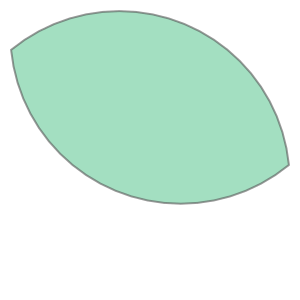

In [26]:
route_area

In [29]:
bbox

(2137007.8268966763, 2117685.473060402, 6066856.805289252, 6038989.477931944)

c:\Users\katar\anaconda3\envs\pp275\lib\site-packages\geopandas\tools\clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


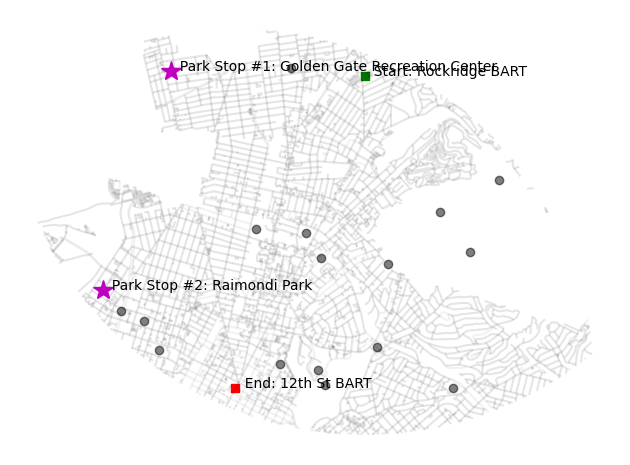

In [24]:
# VISUALIZE
fig, ax = plt.subplots(ncols=1, tight_layout=True)
edges.clip(route_area).plot(ax=ax, color = 'k', alpha = 0.05)
EB_CPAD_centroids.clip(route_area).plot(ax=ax, color ='k', alpha = 0.5)
# possible_parks.plot(ax=ax, color = 'g')
ax.scatter(orig_x, orig_y, marker = ',', c='g')
ax.text(orig_x+2, orig_y+3, '  Start: Rockridge BART')
ax.scatter(final_dest_x, final_dest_y, marker = ',', c='r')
ax.text(final_dest_x+2, final_dest_y+3, '  End: 12th St BART')
ax.plot(park1_final.x, park1_final.y, marker = '*', c='m', markersize = 15)
ax.text(park1_final.x+2, park1_final.y+3, f'  Park Stop #1: {park1_name}')
ax.plot(park2_final.x, park2_final.y, marker = '*', c='m', markersize = 15)
ax.text(park2_final.x+2, park2_final.y+3, f'  Park Stop #2: {park2_name}')
ax.axis('off')
fig.savefig('Analysis_Nodes.jpg')

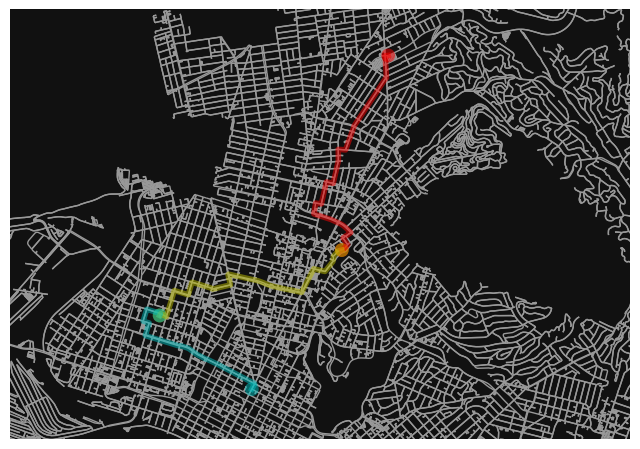

In [ ]:
# USE OSMNX FOR NETWORK ANALYSIS
# graph_new = ox.graph.graph_from_polygon(route_area)

# GET NEAREST NODES TO ALL 
orig_node = ox.nearest_nodes(graph_proj, orig_x, orig_y)
park1_node = ox.nearest_nodes(graph_proj, park1_final.x, park1_final.y)
park2_node = ox.nearest_nodes(graph_proj, park2_final.x, park2_final.y)
final_dest_node = ox.nearest_nodes(graph_proj, final_dest_x, final_dest_y)

# CALCULATE SHORTEST PATH FOR ALL THREE PARTS OF THE BIKE PARTY
# straight_route = ox.shortest_path(graph_proj, orig_node, dest3_node, weight = 'distance')
route1 = nx.shortest_path(graph_proj, orig_node, park1_node, weight = 'distance')
route2 = nx.shortest_path(graph_proj, park1_node, park2_node, weight = 'distance')
route3 = nx.shortest_path(graph_proj, park2_node, final_dest_node, weight = 'distance')

# VISUALIZE COMPLETE ROUTE (RANDOM PARKS EVERYTIME)
routes = [route1, route2, route3]
rc = ['r', 'y', 'c']
pt = ox.graph_to_gdfs(graph, edges=False).unary_union.centroid
west, south, east, north = route_area.bounds
bbox = (north, south, east, west)
fig, ax = ox.plot_graph_routes(graph_proj, routes, route_colors=rc, node_size=0, bbox=bbox)
fig.savefig('Final_Route.jpg')